# Inside AirBnB

## Enunciado

Este Notebook consiste en la actividad evaluable correspondiente al Módulo 1 de la Asignatura de Aprendizaje Automático I del Máster en Ingeniería y Ciencia de Datos de la UNED.

La actividad constituye en un ejercicio de clasificación empleando los tres métodos descritos en el tema y la aplicación de varias de las técnicas estudiadas en el Tema 2.

### 1. Datos

Los datos provienen de la web InsideAirBnB, dedicada al estudio de los alquileres vacacionales ofrecidos en la plataforma AirBnB. El fichero está contenido dentro de la carpeta input-data. Este fichero es una versión editada, a fin de facilitar la tarea, del listado original de información sobre las ofertas existentes, para la ciudad de Madrid, en abril de 2017. 

> Contiene 13321 registros con 11 campos cada uno, correspondientes a diferentes características de cada oferta de alojamiento.

La tarea de clasificación consistirá en clasificar los datos según el tipo de alojamiento, definido en el campo `room_type`, a partir del resto de características. Es decir, en room_type estarán codificadas las clases y en el resto de campos los atributos.

### 2. Estudio estadístico y limpieza de datos

Se realizará un breve estudio estadístico de los datos numéricos y de la variable `room_type` se contarán los valores de cada clase. Si las clases no estuvieran balanceadas habrá que usar los mecanismos que puedan tener los algoritmos de clasificación para tratar con este caso. Para Naive Bayes ya se habla de esto en la actividades autoevaluables, para los otros métodos consultar en la documentación de sus APIs los parámetros de los constructores para ver si hay mecanismos para balancear.
En cuanto a la limpieza de datos estudiar si hay datos faltantes, transformar datos categóricos y escalar datos numéricos haciendo uso de pipelines cuando sea posible.

### 3. Entrenamiento y validación

1. Dividir los datos en conjunto de entrenamiento y test de manera que el conjunto de test sea un 20 % del total.
2. Evaluar los modelos midiendo la exactitud (accuracy) usando validación cruzada para los tres métodos estudiados utilizando los parámetros por defecto de los tres métodos, salvo lo comentado para el balance, para cross_val_score usar cv=10. Comparar los resultados de los tres modelos.
3. Realizar la afinación de hiperparámetros para KNN y Árboles de decisión empleando Grid- SearchCV, Naive Bayes no tiene hiperparámetros que afinar.
    1. Para KNN buscando el valor óptimo de K.
    2. Para Árboles de decisión: variando max_leaf_nodes entre 2 y 50 ambos inclusive , min_samples_split entre 2 y 6 ambos inclusive y max_depth entre 1 y 20 ambos in- clusive. Ver la documentación de la API.

### 4. Valoración

Se valorará la creación del código que realice los requisitos enumerados, la presencia de comentarios de lo que hace el código y sus resultados y las comparaciones entre los resultados obtenidos por los distintos algoritmos, así como algún gráfico que muestre los resultados. Para terminar incluir un apartado de conclusiones. Tanto los comentarios como las conclusiones no es necesario que sea extensos, sino que describan de forma concisa.

## Realización del ejercicio

Antes de empezar a "ensuciarnos las manos", vamos a importar todos los paquetes necesarios, de los que iremos haciendo uso a lo largo del ejercicio:

In [37]:
import pandas as pd
import numpy as np
import operator
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

### Recogida de datos

En primer lugar, vamos a cargar los datos con los que vamos a trabajar. Estos datos están ubicados en la carpeta "input-data", en un fichero llamado "airbnb.csv". Para ello, usaremos el método `read_csv()` de pandas.

In [2]:
airbnb = pd.read_csv("input-data/airbnb.csv")

## Estudio estadístico y limpieza de datos


Comprobamos que los datos se han cargado correctamente y visualizamos nuestros datos por encima:

In [3]:
airbnb

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250
...,...,...,...,...,...,...,...,...,...,...,...
13316,Centro,Justicia,40.427500,-3.698354,Private room,14,1,0,0.00,1,10
13317,Chamberí,Gaztambide,40.431187,-3.711909,Entire home/apt,47,1,0,0.00,7,354
13318,Centro,Palacio,40.413552,-3.711461,Entire home/apt,60,2,0,0.00,1,17
13319,Centro,Universidad,40.425400,-3.709921,Entire home/apt,150,5,0,0.00,1,15


Seguidamente, realizamos un `describe()` para echarle un ojo a toda la información sobre los datos que tenemos.

In [4]:
airbnb.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


Y también, usamos el método `info()`para ver la estructura de los datos:

In [5]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
neighbourhood_group               13321 non-null object
neighbourhood                     13321 non-null object
latitude                          13321 non-null float64
longitude                         13321 non-null float64
room_type                         13321 non-null object
price                             13321 non-null int64
minimum_nights                    13321 non-null int64
number_of_reviews                 13321 non-null int64
reviews_per_month                 13321 non-null float64
calculated_host_listings_count    13321 non-null int64
availability_365                  13321 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


Las conclusiones que podemos sacar visualizando la siguiente información son las siguientes:
- No hay valores a `null` ya que todos los `count` tienen el mismo valor.
- `neighbourhood_group`, `neighbourhood` y `room_type`son features categoricas.

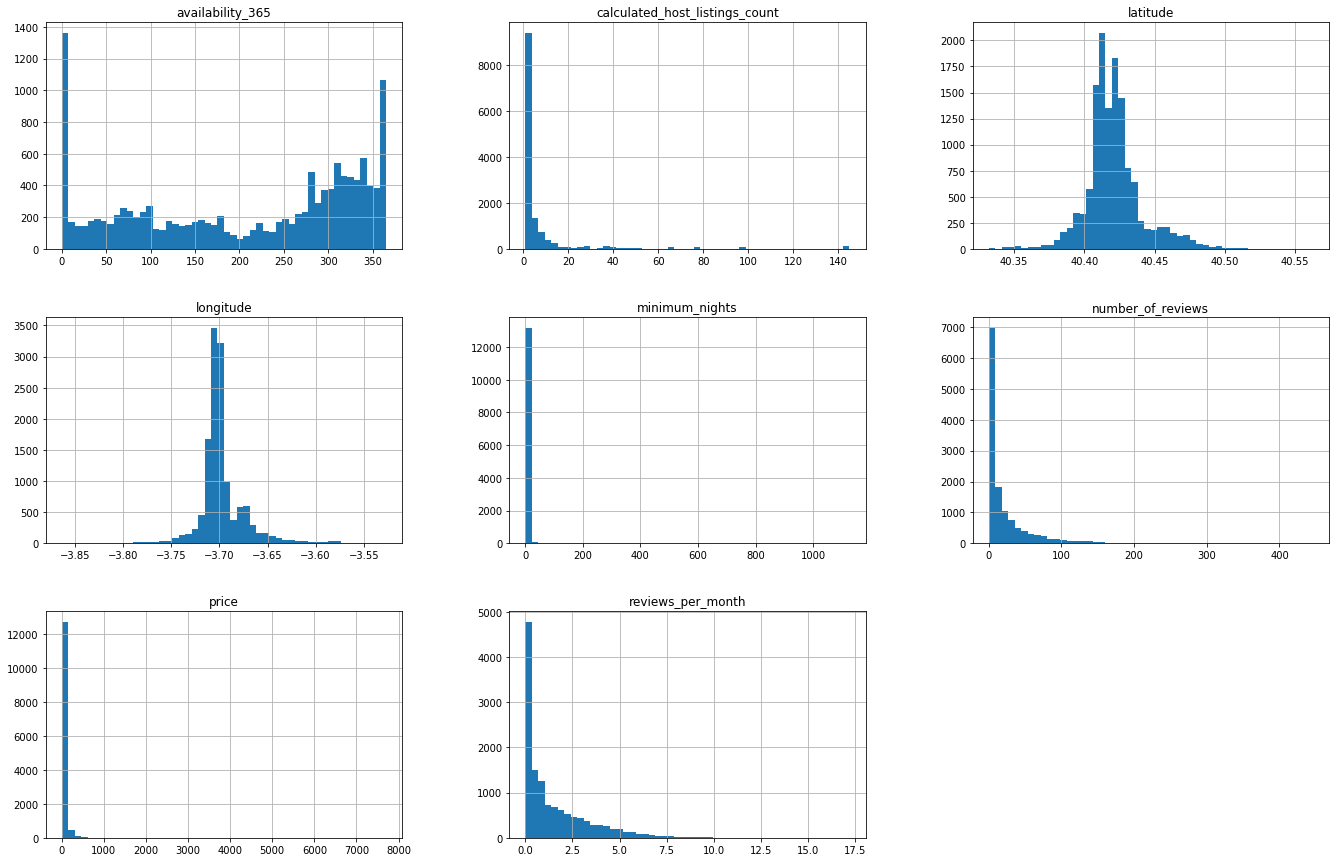

In [6]:
airbnb.hist(bins=50, figsize=(23,15))
plt.show()

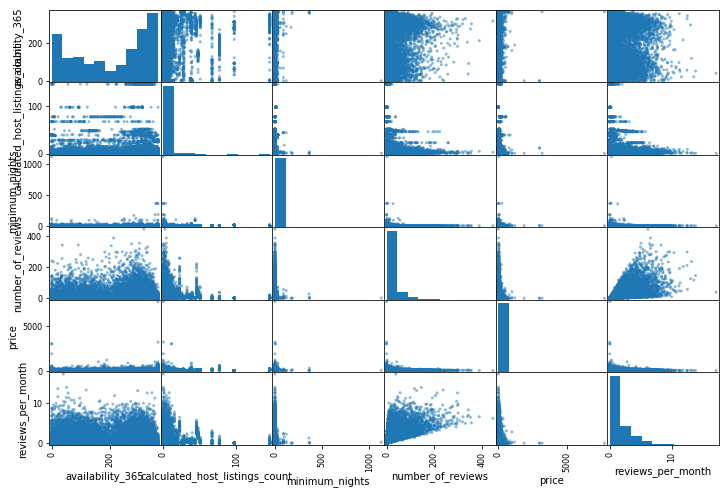

In [7]:
attributes = ["availability_365","calculated_host_listings_count","minimum_nights","number_of_reviews", "price", "reviews_per_month"]
scatter_matrix = scatter_matrix(airbnb[attributes], figsize=(12,8))

## Create the test set

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(airbnb, airbnb["neighbourhood_group"]):
    strat_train_set = airbnb.loc[train_indices]
    strat_test_set = airbnb.loc[test_indices]

In [9]:
X_train = strat_train_set
X_test = strat_test_set
y_train = X_train["room_type"]
y_test = X_test["room_type"]
X_train.drop(columns=["room_type"], inplace=True)
X_test.drop(columns=["room_type"], inplace=True)

In [39]:
full_pipeline_onehot = ColumnTransformer([
    ("neighbours_onehot", OneHotEncoder(), ["neighbourhood_group", "neighbourhood"])
], remainder='passthrough')

full_pipeline_ordenc = ColumnTransformer([
    ("neighbours_ordenc", OrdinalEncoder(), ["neighbourhood_group", "neighbourhood"])
], remainder='passthrough')

In [40]:
X_train_transformed_onehot = full_pipeline_onehot.fit_transform(X_train)
X_train_transformed_ordenc = full_pipeline_ordenc.fit_transform(X_train)

In [41]:
#column_names_transformed = full_pipeline_onehot.named_transformers_.neighbours_onehot.categories_
column_names_transformed = full_pipeline_ordenc.named_transformers_.neighbours_ordenc.categories_
column_names = ["latitude","longitude","price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]

In [49]:
# X_train_transformed = pd.DataFrame(X_train_transformed_onehot.toarray(), columns=[*column_names_transformed[0], *column_names_transformed[1], *column_names])[[*column_names]]
X_train_transformed = pd.DataFrame(X_train_transformed_ordenc, columns=["neighbourhood_group", "neighbourhood", *column_names])

In [50]:
X_train_transformed

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,3.0,114.0,40.422239,-3.704536,55.0,2.0,103.0,3.24,23.0,313.0
1,3.0,48.0,40.410082,-3.696771,60.0,2.0,13.0,0.39,2.0,212.0
2,14.0,56.0,40.433707,-3.669566,19.0,2.0,5.0,0.28,14.0,344.0
3,13.0,79.0,40.402038,-3.675355,26.0,1.0,30.0,5.14,4.0,72.0
4,3.0,62.0,40.422054,-3.697999,60.0,2.0,16.0,3.27,3.0,268.0
...,...,...,...,...,...,...,...,...,...,...
10651,16.0,115.0,40.461850,-3.700078,55.0,5.0,1.0,0.23,1.0,313.0
10652,3.0,80.0,40.419016,-3.717999,55.0,3.0,18.0,3.02,1.0,115.0
10653,3.0,80.0,40.410960,-3.710580,230.0,1.0,23.0,0.67,1.0,327.0
10654,3.0,39.0,40.411957,-3.696432,65.0,2.0,65.0,2.29,1.0,335.0


## Naive Baye's

In [51]:
model = GaussianNB()
model.fit(X_train_transformed, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [52]:
y_temp = model.predict(X_train_transformed)

In [54]:
mat = confusion_matrix(y_train.array, y_temp)
mat

array([[4274, 1944,  116],
       [1018, 2586,  558],
       [  26,   98,   36]])

In [55]:
naive_bayes_score = cross_val_score(model, X_train_transformed, y_train, cv=10)

In [56]:
naive_bayes_score

array([0.62605436, 0.66729147, 0.62288931, 0.61538462, 0.63755869,
       0.62816901, 0.59248826, 0.64131455, 0.65633803, 0.64319249])